In [4]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [5]:
N_CONCEPTS = 2
N_STUDENTS = 10
N_ATTEMPTS = 3
N_QUESTIONS = 5

# Algorithm parameters
INIT = 3
MAX_ITER = 100

### ALS Tensor Factorization

In [353]:
def als_tensor_factorization(student_performance, n_concepts=2, init=3, max_iter=100):
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

    error_run = []
    error_total_run = []
    student_performance_pred_run = []
    
    # Several starts
    for run in range(init):
        error = []
        student_performance_pred_list = []
    #     q_matrix = np.random.rand(N_QUESTIONS, N_CONCEPTS)

        for attempt in range(N_ATTEMPTS):
            student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)

        # Phase 1: prediction
        student_performance_pred = np.zeros((n_students, n_questions, n_attempts))
        for i in range(max_iter):

            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed)
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            q_matrix = q_matrix / row_sums
            
            # Update T: T = YQ'(QQ')^(-1) = YQ^(-1)
            # (QQ')^(-1)
            q_matrix_transpose_inv = np.linalg.pinv(np.dot(q_matrix, q_matrix.T))
            
            # YQ'
            YQ = np.zeros((n_students, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                YQ[:, :, attempt] = np.dot(student_performance[:, :, attempt], q_matrix.T)
                
            # T = YQ'(QQ')^(-1)
            for attempt in range(n_attempts):
                student_knowledge[:, :, attempt] = np.dot(YQ[:, :, attempt], q_matrix_transpose_inv)
                
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error.append(np.sqrt(np.sum(np.power(diff, 2))))
            
            student_performance_pred_iter = student_performance_pred.copy()
            student_performance_pred_list.append(student_performance_pred_iter)
        student_performance_pred_run.append(student_performance_pred_list)
        error_run.append(error)
        error_total_run.append(error[-1])
                
            
    return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run

In [94]:
def als_tensor_factorization_t(student_performance, n_concepts=2, init=3, max_iter=100):
    
    # Get values from student performance tensor shape
    n_questions, n_students, n_attempts = student_performance.shape
    
    student_knowledge = np.zeros((n_concepts, n_students, n_attempts))

    error_run = []
    error_total_run = []
    student_performance_pred_run = []
    
    # Several starts
    for run in range(init):
        error = []
        student_performance_pred_list = []
    #     q_matrix = np.random.rand(N_QUESTIONS, N_CONCEPTS)

        for attempt in range(N_ATTEMPTS):
            student_knowledge[:, :, attempt] = np.random.rand(n_concepts, n_students)

        # Phase 1: prediction
        student_performance_pred = np.zeros((n_questions, n_students, n_attempts))
        for i in range(max_iter):

            # Update Q: Q = YT'(TT')^(-1) = YT^(-1)
            # (TT')^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], 
                                                                     student_knowledge[:, :, attempt].T)
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed)
            
            # YT'
            YT = np.zeros((n_questions, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                YT[:, :, attempt] = np.dot(student_performance[:, :, attempt],
                                                      student_knowledge[:, :, attempt].T)
            YT = YT.sum(axis=2) 
            
            ## TODO: add regularization parameters (lambda)
            # Q = YT'(TT')^(-1)
            q_matrix = np.dot(YT, student_knowledge_transposed_inv)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=1, keepdims=True)
            q_matrix = q_matrix / row_sums
            
            # Update T: T = (Q'Q)^(-1)Q'Y = Q^(-1)Y
            # (Q'Q)^(-1)
            q_matrix_transpose_inv = np.linalg.pinv(np.dot(q_matrix.T, q_matrix))
            
            # Q'Y
            QY = np.zeros((n_concepts, n_students, n_attempts))
            for attempt in range(n_attempts):
                QY[:, :, attempt] = np.dot(q_matrix.T, student_performance[:, :, attempt])
                
            # T = (Q'Q)^(-1)Q'Y    
            for attempt in range(n_attempts):
                student_knowledge[:, :, attempt] = np.dot(q_matrix_transpose_inv, QY[:, :, attempt])
                
            # Y = QT
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(q_matrix, student_knowledge[:, :, attempt])
                
            
            diff = np.zeros((n_questions, n_students, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error.append(np.sqrt(np.sum(np.power(diff, 2))))
            
            student_performance_pred_iter = student_performance_pred.copy()
            student_performance_pred_list.append(student_performance_pred_iter)
        student_performance_pred_run.append(student_performance_pred_list)
        error_run.append(error)
        error_total_run.append(error[-1])
                
            
    return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run

### Simulation 1 - Student Performance is the exact multiplication of  Q Matrix and Student Knowledge

In [72]:
def generate_sample(noise=0):
    DENSITY = 0.8

    # Create sparse q_matrix and normalize it to sum 1
    q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
    row_sums = q_matrix.sum(axis=0)
    while not(np.all(row_sums)):
        q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
        row_sums = q_matrix.sum(axis=0)
    q_matrix = q_matrix / row_sums

    student_knowledge = np.zeros((N_STUDENTS, N_CONCEPTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_knowledge[:, :, attempt] = sparse.rand(N_STUDENTS, N_CONCEPTS, DENSITY).todense()

    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_performance[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
        
    if noise:
        noise = np.random.normal(0, noise, (N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
        student_performance = student_performance + noise
        
    return student_performance

In [245]:
def generate_sample(noise=0):
    DENSITY = 0.8

    # Create sparse q_matrix and normalize it to sum 1
    q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
    row_sums = q_matrix.sum(axis=0)
    while not(np.all(row_sums)):
        q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
        row_sums = q_matrix.sum(axis=0)
    q_matrix = q_matrix / row_sums
    q_matrix_t = q_matrix.copy().T

    student_knowledge = np.zeros((N_STUDENTS, N_CONCEPTS, N_ATTEMPTS))
    student_knowledge_t = np.zeros((N_CONCEPTS, N_STUDENTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_knowledge[:, :, attempt] = sparse.rand(N_STUDENTS, N_CONCEPTS, DENSITY).todense()
        student_knowledge_t[:, :, attempt] = student_knowledge[:, :, attempt].copy().T

    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
    student_performance_t = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_performance[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
        student_performance_t[:, :, attempt] = student_performance[:, :, attempt].copy().T
        
    if noise:
        noise = np.random.normal(0, noise, (N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
        student_performance = student_performance + noise
        for attempt in range(N_ATTEMPTS):
            student_performance_t[:, :, attempt] = student_performance_t[:, :, attempt] + noise[:,:,attempt].T
        
    return student_performance, student_performance_t

In [363]:
student_performance, student_performance_t = generate_sample()

In [364]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=1, max_iter=4)

In [365]:
_, error_run_t, error_total_run_t = als_tensor_factorization_t(
    student_performance_t, n_concepts=2, init=1, max_iter=4)

In [366]:
error_run

array([[1.66094257e-01, 8.22915003e-13, 1.03785189e-12, 1.16584694e-12]])

In [367]:
error_run_t

array([[1.77085128e-01, 4.97722607e-13, 1.36754112e-12, 8.68726308e-13]])

### Simulation 2 - Student Performance is the multiplication of Q Matrix and Student Knowledge plus noise

In [368]:
student_performance, student_performance_t = generate_sample(0.5)

In [369]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=50)

In [370]:
_, error_run_t, error_total_run = als_tensor_factorization_t(
    student_performance_t, n_concepts=2, init=3, max_iter=50)

In [371]:
error_run

array([[4.64250126, 4.40180233, 4.3158876 , 4.29768878, 4.29301625,
        4.29318463, 4.29466717, 4.29520412, 4.29539269, 4.29545828,
        4.29548102, 4.29548891, 4.29549164, 4.29549259, 4.29549292,
        4.29549304, 4.29549308, 4.29549309, 4.2954931 , 4.2954931 ,
        4.2954931 , 4.29525944, 4.29323412, 4.29209833, 4.29143434,
        4.29103473, 4.29078947, 4.29063699, 4.2905414 , 4.29048115,
        4.29044306, 4.29041892, 4.2904036 , 4.29039387, 4.2903877 ,
        4.29038377, 4.29038127, 4.29037969, 4.29037868, 4.29037804,
        4.29037763, 4.29037737, 4.2903772 , 4.2903771 , 4.29037703,
        4.29037699, 4.29037696, 4.29037695, 4.29037693, 4.29037693],
       [5.00771677, 4.9834224 , 4.92193845, 4.7762323 , 4.57115861,
        4.40143683, 4.31397023, 4.28679614, 4.28238134, 4.28308779,
        4.28415287, 4.28482076, 4.28516327, 4.28532238, 4.28539059,
        4.28541693, 4.28542519, 4.28542629, 4.28542497, 4.28542315,
        4.28542153, 4.28542027, 4.28541935, 4.2

In [372]:
error_run_t

array([[4.5620421 , 4.34323147, 4.29935185, 4.28921054, 4.28662935,
        4.28584803, 4.28558467, 4.28548925, 4.28545204, 4.28543607,
        4.28542837, 4.28542422, 4.28542176, 4.28542024, 4.28541926,
        4.28541862, 4.28541821, 4.28541794, 4.28541777, 4.28541765,
        4.28541758, 4.28541753, 4.2854175 , 4.28541748, 4.28541747,
        4.28541746, 4.28541745, 4.28541745, 4.28541745, 4.28541745,
        4.28541745, 4.28541745, 4.28541744, 4.28541744, 4.28541744,
        4.28541744, 4.28541744, 4.28541744, 4.28541744, 4.28541744,
        4.28541744, 4.28541744, 4.28541744, 4.28541744, 4.28541744,
        4.28541744, 4.28541744, 4.28541744, 4.28541744, 4.28541744],
       [4.73391114, 4.41950516, 4.31775128, 4.2939333 , 4.28894734,
        4.28829739, 4.28852691, 4.28882667, 4.28904389, 4.28917908,
        4.28828282, 4.28674708, 4.28605781, 4.28573606, 4.28558122,
        4.28550449, 4.28546528, 4.28544457, 4.28543327, 4.2854269 ,
        4.2854232 , 4.285421  , 4.28541967, 4.2

### Simulation 3 - Student Performance contains only zeros and ones

In [384]:
student_performance, student_performance_t = generate_sample(0.5)

In [385]:
student_performance[student_performance > 0.5] = 1
student_performance[student_performance < 0.5] = 0

In [386]:
student_performance_t[student_performance_t > 0.5] = 1
student_performance_t[student_performance_t < 0.5] = 0

In [387]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=100)

In [388]:
student_performance_pred_run_t, error_run_t, error_total_run = als_tensor_factorization_t(
    student_performance_t, n_concepts=2, init=3, max_iter=100)

In [389]:
best_run = np.unravel_index(error_run.argmin(), error_run.shape)
best_student_performance_pred = student_performance_pred_run[best_run]

In [390]:
best_run_t = np.unravel_index(error_run_t.argmin(), error_run_t.shape)
best_student_performance_pred_t = student_performance_pred_run_t[best_run_t]

In [391]:
best_student_performance_pred[best_student_performance_pred > 0.5] = 1
best_student_performance_pred[best_student_performance_pred < 0.5] = 0

In [392]:
best_student_performance_pred_t[best_student_performance_pred_t > 0.5] = 1
best_student_performance_pred_t[best_student_performance_pred_t < 0.5] = 0

In [393]:
acc = 100*(np.logical_not(np.logical_xor(
    student_performance, best_student_performance_pred)).sum())/(
    student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
print("Accuracy: %.2f%%" % acc)

Accuracy: 78.67%


In [394]:
acc = 100*(np.logical_not(np.logical_xor(
    student_performance_t, best_student_performance_pred_t)).sum())/(
    student_performance_t.shape[0]*student_performance_t.shape[1]*student_performance_t.shape[2])
print("Accuracy: %.2f%%" % acc)

Accuracy: 78.67%


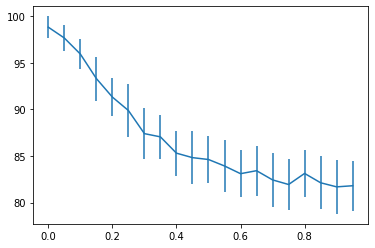

CPU times: user 1min 16s, sys: 11.9 ms, total: 1min 16s
Wall time: 1min 16s


In [360]:
%%time
accs = []
accs_std = []
accs_t = []
accs_std_t = []
for noise in np.arange(0, 1, 0.05):
    accs_run = []
    accs_run_t = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance, student_performance_t = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0
        

#         Run tensor factorization
        student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)
        

#         Get best run results
        best_run = np.unravel_index(error_run.argmin(), error_run.shape)
        best_student_performance_pred = student_performance_pred_run[best_run]
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0
        

#         Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)

        student_performance_t[student_performance_t > 0.5] = 1
        student_performance_t[student_performance_t < 0.5] = 0
        student_performance_pred_run_t, error_run_t, error_total_run = als_tensor_factorization_t(
            student_performance_t, n_concepts=2, init=3, max_iter=50)
        best_run_t = np.unravel_index(error_run_t.argmin(), error_run_t.shape)
        best_student_performance_pred_t = student_performance_pred_run_t[best_run_t]
        best_student_performance_pred_t[best_student_performance_pred_t > 0.5] = 1
        best_student_performance_pred_t[best_student_performance_pred_t < 0.5] = 0
        acc_t = 100*(np.logical_not(np.logical_xor(
            student_performance_t, best_student_performance_pred_t)).sum())/(
            student_performance_t.shape[0]*student_performance_t.shape[1]*student_performance_t.shape[2])
        accs_run_t.append(acc_t)
        
    accs_t.append(np.asarray(accs_run_t).mean())
    accs_std_t.append(np.asarray(accs_run_t).std())
    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()
# plt.errorbar(np.arange(0, 0.05, 0.05), accs_t, yerr=accs_std_t)
# plt.show()

In [362]:
accs

[98.32,
 97.57333333333332,
 96.02666666666666,
 94.43999999999998,
 90.97333333333331,
 90.06666666666666,
 87.82666666666668,
 86.29333333333334,
 85.49333333333333,
 84.89333333333335,
 83.90666666666667,
 83.89333333333335,
 83.61333333333332,
 83.32,
 82.46666666666665,
 82.38666666666666,
 81.8,
 81.81333333333333,
 81.94666666666666,
 82.02666666666669]

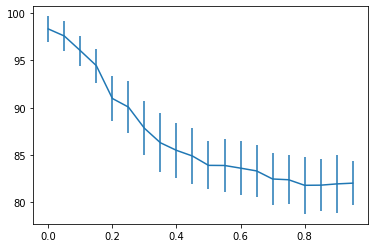

CPU times: user 1min 16s, sys: 28 ms, total: 1min 16s
Wall time: 1min 16s


In [361]:
%%time
accs = []
accs_std = []
for noise in np.arange(0, 1, 0.05):
    accs_run = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance, student_performance_t = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0

        # Run tensor factorization
        student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)

        # Get best run results
        best_run = np.unravel_index(error_run.argmin(), error_run.shape)
        best_student_performance_pred = student_performance_pred_run[best_run]
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0

        # Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)
    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()

In [485]:
diff = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
for attempt in range(N_ATTEMPTS):
    diff[:, :, attempt] = student_performance[:, :, attempt] - best_student_performance_pred[:, :, attempt]

In [486]:
np.sqrt(np.sum(np.power(diff, 2)))

4.898979485566356